### 0. Import libraries ###

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 16 09:35:11 2020
@author: hongli
"""
import os
import numpy as np
import rasterio as rio
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt 
import geospatial_functions.geospatial as gs

print('Done')

Done


### 0. Specify file paths ###

In [2]:
# main script
case = 'yampa'

# --- common source file paths ---
root_dir = '/glade/u/home/hongli/scratch/2020_11_29discretization_error'

dem_raster = os.path.join(root_dir, 'source_data/MERIT_Hydro_dem_NLDAS.tif')
dem_raster_prj = os.path.join(root_dir, 'source_data/MERIT_Hydro_dem_NLDAS_prj.tif')

lc_raster = os.path.join(root_dir, 'source_data/nldas_landcover.tif') 
lc_raster_prj = os.path.join(root_dir, 'source_data/nldas_landcover_prj.tif')

# --- case study depedent file paths ----
case_dir = os.path.join(root_dir, case)
sub_shp = os.path.join(case_dir, 'huc12.shp')
if not os.path.exists(case_dir):
    os.makedirs(case_dir)

buf_dist = 600 # meter
    
dem_crop = os.path.join(case_dir, 'dem_crop.tif')
dem_crop_buf = os.path.join(case_dir, 'dem_crop_buf.tif')
dem_class_raster = os.path.join(case_dir, 'dem_class.tif')
dem_value_raster = os.path.join(case_dir, 'dem_value.tif')

slp_crop_buf = os.path.join(case_dir, 'slope_crop_buf.tif')
slp_crop = os.path.join(case_dir, 'slope_crop.tif')
slp_class_raster = os.path.join(case_dir, 'slope_class.tif')
slp_value_raster = os.path.join(case_dir, 'slope_value.tif')

asp_crop_buf = os.path.join(case_dir, 'aspect_crop_buf.tif')
asp_crop = os.path.join(case_dir, 'aspect_crop.tif')
asp_crop_180 = os.path.join(case_dir, 'aspect_crop_180.tif')
asp_class_raster = os.path.join(case_dir, 'aspect_class.tif')
asp_value_raster = os.path.join(case_dir, 'aspect_value.tif')

lc_crop = os.path.join(case_dir, 'landcover_crop.tif')
lc_crop_resample = os.path.join(case_dir, 'landcover_crop_resample.tif')
lc_class_raster = os.path.join(case_dir, 'landcover_class.tif')

sx_raster = os.path.join(case_dir, 'step7_merge_raw_Sx/sx.tif')
sw_raster = os.path.join(case_dir, 'step9_merge_raw_Sw/sw.tif')
sw_daily_dir = os.path.join(case_dir, 'step8_raw_Sw')

sub_shp_prj = os.path.join(case_dir, 'subbasin_prj.shp')
sub_shp_prj_buf = os.path.join(case_dir, 'subbasin_prj_buf.shp')
sub_raster = os.path.join(case_dir, 'subbasin.tif')
sub_corr_txt=os.path.join(case_dir, 'subNo_HUC12_corr.txt') #correspondence between HUC12 and subbasin number.
 
hru_raster = os.path.join(case_dir, 'hru.tif')
hru_vector = os.path.join(case_dir, 'hru.shp')
hru_raster_diss = os.path.join(case_dir, 'hru_diss.tif')
hru_vector_diss = os.path.join(case_dir, 'hru_diss.shp')

hru_raster_diss_domimant = os.path.join(case_dir, 'hru_diss_domimant.tif')
hru_vector_diss_domimant = os.path.join(case_dir, 'hru_diss_domimant.shp')
hru_raster_diss_neighbor = os.path.join(case_dir, 'hru_diss_neighbor.tif')
hru_vector_diss_neighbor = os.path.join(case_dir, 'hru_diss_neighbor.shp')

hru_attrb_elev = os.path.join(case_dir, 'hru_attrb_elevation.tif') # attribute raster of HRU
hru_attrb_lc = os.path.join(case_dir, 'hru_attrb_landcover.tif')
hru_attrb_slp = os.path.join(case_dir, 'hru_attrb_slope.tif')
hru_attrb_asp = os.path.join(case_dir, 'hru_attrb_aspect.tif')
hru_attrb_sw_mean = os.path.join(case_dir, 'hru_attrb_sw_mean.tif')
hru_attrb_sw_basename = os.path.join(case_dir, 'hru_attrb_sw_DOY') # e.g., hru_attrb_sw_DOY100.tif

error_file = os.path.join(case_dir, 'Diagnostics.txt')
hist_ofile = os.path.join(case_dir, 'plot/Sw_histgram.png')
cdf_ofile = os.path.join(case_dir, 'plot/Sw_cdf.png')

# -- define GRU and HRU field names and data types --
subNo_field = 'GRUNo'
subNo_field_type = 'int32'
subName_field = 'GRUId'

hruNo_field = 'HRUNo'
hruNo_field_type = 'int32'
hruName_field = 'HRUId'

area_field = 'areaSqm'

# --- define common projection, nodata value, reference raster----
proj4="+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs"
dst_crs = rio.crs.CRS.from_string(proj4)
## Albers Equal Area Conic Projection. 
## reference 1: https://gisgeography.com/conic-projection-lambert-albers-polyconic/
## reference 2: https://epsg.io/102008
nodatavalue = -9999  
refraster = dem_crop # reference raster to rasterize vector and resample

# HRU elimination threshold
hru_area_thld = 10**6 #1km2
print('Done')

Done


### 0. Project large rasters (once for all) ###

In [10]:
# # --- PART 1. reproject dem and landcover rasters --- 
# print('PART 1. reproject dem and landcover rasters')
# gs.reproject_raster(dem_raster, dem_raster_prj, dst_crs) # re-project dem raster
# gs.reproject_raster(lc_raster, lc_raster_prj, dst_crs)   # re-project land cover raster

# print('Done')

PART 1. reproject dem and landcover rasters
Done


### 1. Project rasters and vectors, crop rasters ###

In [3]:
# --- PART 1. reproject rasters and basin vector --- 
print('PART 1. reproject case basin vector')
gs.reproject_vector(sub_shp, sub_shp_prj, dst_crs)       # re-project subbasin shapefile

# --- PART 2. crop dem raster ---
print('PART 2. crop dem, slope and aspect rasters')
# (1) crop based on original basin extent
gs.crop_raster(dem_raster_prj,sub_shp_prj,dem_crop,nodatavalue)

# (2-1) crop DEM based on buffered basin extent 
gs.buffer_vector(sub_shp_prj, sub_shp_prj_buf, buf_dist)
gs.crop_raster(dem_raster_prj,sub_shp_prj_buf,dem_crop_buf,nodatavalue)

# (2-2) calculate slope and aspect based on cropped bufferred DEM
gs.calculate_slope_aspect(dem_crop_buf,slp_crop_buf,asp_crop_buf)

# (2-3) crop slope and aspect based on basin extent
gs.crop_raster(slp_crop_buf,sub_shp_prj,slp_crop,nodatavalue)
gs.crop_raster(asp_crop_buf,sub_shp_prj,asp_crop,nodatavalue)

# (2-4) convert aspect from 360 to 180
gs.convert_aspect_180(asp_crop, asp_crop_180)

# --- PART 3. crop landcover raster ---
print('PART 3. crop landcover raster')
# (1) crop based on basin
gs.crop_raster(lc_raster_prj,sub_shp_prj,lc_crop,255) # 255 is nodatavalue for landcover raster

# (2) resample landcover to the reference raster resolution
gs.resample_raster(lc_crop,refraster,lc_crop_resample) 

# --- PART 4. rasterize subbasin vector ---
print('PART 4. rasterize subbasin vector')
infield = 'HUC12'
infield_rename = subName_field
gs.rasterize_subbasin_vector(sub_shp_prj,infield,infield_rename,subNo_field,subNo_field_type,
                             refraster,sub_raster,sub_corr_txt,nodatavalue)

print('Done')

PART 1. reproject case basin vector
PART 2. crop dem, slope and aspect rasters
PART 3. crop landcover raster
PART 4. rasterize subbasin vector
Done


### 2. Classify elevation and landcover ### 

In [4]:
# --- PART 1. relassify elevation raster within each subbasin ---
print('PART 1. classify elevation raster')
bins = [2000,2250,2500,2750,3000,3250,3500,3750] # including the rightmost edge
# bins = [2000,2500,3000,3500,4000] # including the rightmost edge
bins.sort()
gs.classify_elevation(dem_crop, sub_raster, bins, dem_class_raster, dem_value_raster, nodatavalue)

# # # --- PART 2. relassify landcover raster ---
# print('PART 2. relassify landcover raster')
# # Note: here we make only two classes: crop vs. non-crop
# # Crop class includes: 0 Evergreen needleleaf forests, 1 Evergreen broadleaf forests, 
# # 2 Deciduous needleleaf forests, 3 Deciduous broadleaf forests, 4 Mixed forests, 7 Woody savannas.  
# gs.classify_landcover(lc_crop_resample, lc_class_raster, nodatavalue)
  
print('Done')

PART 1. classify elevation raster
Done


### 3. Classify slope and aspect and gnerate HRU ### 

PART 1. classify slope raster


/glade/u/home/hongli/tools/miniconda3/envs/conda_hongli/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/u/home/hongli/tools/miniconda3/envs/conda_hongli/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


PART 2. relassify aspect raster
PART 3. genearte HRU


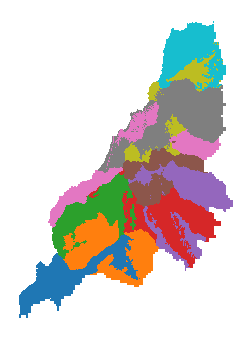

PART 4. zonal area
Done
PART 5. Sw zonal statistics 
Done


In [3]:
scheme = 'non-dom1566'
slp_bins = [0,2.819672e+01, 1.170063e+01,1.000000e-03,53] 
asp_bins = [-1,0,2.991127e+01, 1.286601e+02, 9.970486e+01,181] 
#array([1.566000e+03, 1.852700e-02, 2.819672e+01, 1.170063e+01,
#        1.000000e-03, 2.991127e+01, 1.286601e+02, 9.970486e+01]))

slp_class_raster = os.path.join(case_dir, 'slope_class_'+scheme+'.tif')
slp_value_raster = os.path.join(case_dir, 'slope_value_'+scheme+'.tif')
asp_class_raster = os.path.join(case_dir, 'aspect_class_'+scheme+'.tif')
asp_value_raster = os.path.join(case_dir, 'aspect_value_'+scheme+'.tif')
hru_raster = os.path.join(case_dir, 'hru_'+scheme+'.tif')
hru_vector = os.path.join(case_dir, 'hru_'+scheme+'.shp')
hru_attrb_sw_mean = os.path.join(case_dir, 'hru_attrb_sw_mean_'+scheme+'.tif')
error_file = os.path.join(case_dir, 'Diagnostics_'+scheme+'.txt')
hist_ofile = os.path.join(case_dir, 'plot/Sw_histgram_'+scheme+'.png')
cdf_ofile = os.path.join(case_dir, 'plot/Sw_cdf_'+scheme+'.png')

# --- PART 1. relassify slope raster ---
print('PART 1. classify slope raster')
slp_bins.sort()
slp_classes = len(slp_bins)-1
gs.classify_elevation(slp_crop, sub_raster, slp_bins, slp_class_raster, slp_value_raster, nodatavalue)

# --- PART 2. relassify aspect raster ---
print('PART 2. relassify aspect raster')
asp_bins.sort()
slp_classes = len(asp_bins)-1
gs.classify_elevation(asp_crop_180, sub_raster, asp_bins, asp_class_raster, asp_value_raster, nodatavalue)

# --- PART 3. genearte HRU based on subbasin, elevation class, and landcover class (crop, noncrop) ---
print('PART 3. genearte HRU')
raster_list = [sub_raster, dem_class_raster, lc_class_raster, slp_class_raster, asp_class_raster]
raster_fieldname_list = [subNo_field, 'elevClass', 'lcClass', 'slpClass', 'aspClass']

gs.define_hru(raster_list, raster_fieldname_list, sub_raster, sub_corr_txt, subNo_field, subName_field,
              nodatavalue, hru_raster, hru_vector, hruNo_field, hruNo_field_type, hruName_field)
gs.plot_vector(hru_vector, hruName_field) # plot for check

# --- PART 4. zonal area ---
print('PART 4. zonal area')
in_gpd = gpd.read_file(hru_vector)
in_gpd[area_field] = in_gpd.area
in_gpd.to_file(hru_vector)
print('Done')

# --- PART 5. Sw zonal statistics ---
print('PART 5. Sw zonal statistics ')
gs.zonal_statistic(sw_raster, hru_vector, hruNo_field, hruNo_field_type, refraster, 'mean', 
                   hru_attrb_sw_mean, nodatavalue, output_column_prefix='sw')
print('Done')   

### 5. Calculate errors ###

In [4]:
# This script is used to calcualte the CDF difference for shortwave radiation (Sw) and maximum upwind slope (Sx)

def read_raster(raster_file, var_name, area_name):
    with rio.open(raster_file) as ff:
        data_value  = ff.read(1)
        data_mask = ff.read_masks(1)
        gt = ff.transform

    dx = gt[0]
    dy = -gt[4]
    pixelArea = dx*dy

    (unique, counts) = np.unique(data_value[data_mask!=0], return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    frequencies[:,1]=frequencies[:,1]*pixelArea

    df = pd.DataFrame(frequencies, columns = [var_name, area_name]) 
    return df 

def get_cdf_error(raw_df, dis_df, var_column, area_column):

    # get raw grid cell and hru numbers
    raw_num = len(raw_df)
    hru_num = len(dis_df)

    # sort dataframe based on interested variable values
    raw_df_sort = raw_df.sort_values(by=[var_column])
    dis_df_sort = dis_df.sort_values(by=[var_column])
    
    # create evenly spaced variable values 
    line_var_num = 200
    line_var = np.reshape(np.linspace(0.9*np.minimum(np.amin(raw_df_sort[var_column].values), np.amin(dis_df_sort[var_column].values)),
                    1.1*np.maximum(np.amax(raw_df_sort[var_column].values), np.amax(dis_df_sort[var_column].values)),
                    num=line_var_num),[line_var_num,1])
    
    # calculate variable cdf in raw_cdf
    line_var_rep = np.repeat(line_var, raw_num, axis=1) # shape [line_var_num, raw_num]
    raw_var_rep = np.repeat(np.reshape(raw_df_sort[var_column].values, [1, raw_num]), line_var_num, axis=0) 
    raw_area_rep =  np.repeat(np.reshape(raw_df_sort[area_column].values, [1, raw_num]), line_var_num, axis=0)
    
    condition_area = np.where(line_var_rep>raw_var_rep, raw_area_rep, 0.0)
    condition_area_cumsum = np.sum(condition_area, axis=1)
    total_area = np.sum(raw_area_rep, axis=1)
    line_var_cdf_in_raw = np.divide(condition_area_cumsum,total_area)
    del line_var_rep, raw_var_rep, raw_area_rep, condition_area, condition_area_cumsum, total_area
    
    # calculate variable in hru_cdf
    line_var_rep = np.repeat(line_var, hru_num, axis=1) # shape [line_var_num, hru_num]
    dis_var_rep = np.repeat(np.reshape(dis_df_sort[var_column].values, [1, hru_num]), line_var_num, axis=0) 
    hru_area_rep =  np.repeat(np.reshape(dis_df_sort[area_column].values, [1, hru_num]), line_var_num, axis=0)
    
    condition_area = np.where(line_var_rep>dis_var_rep, hru_area_rep, 0.0) # Area array with elements from hru_area_rep where condition is True, and 0 elsewhere.
    condition_area_cumsum = np.sum(condition_area, axis=1)
    total_area = np.sum(hru_area_rep, axis=1)
    line_var_cdf_in_hru = np.divide(condition_area_cumsum,total_area)
    del line_var_rep, dis_var_rep, hru_area_rep, condition_area, condition_area_cumsum, total_area
    
    # calucalte CDF difference
    cdf_dif = np.abs(line_var_cdf_in_raw-line_var_cdf_in_hru)
    line_var = np.reshape(line_var, np.shape(cdf_dif))
    var_error = np.trapz(cdf_dif, x=line_var)

    # relative error (normalized Wasserstein distance)     
    var_base = np.trapz(line_var_cdf_in_raw, x=line_var)    
    var_error_relative = var_error/var_base
    
    #  Kolmogorov–Smirnov statistic
    cdf_dif_max = max(cdf_dif)
    return var_error_relative, cdf_dif_max

sw_var = 'Sw'
sx_var = 'Sx'
area_var = 'area_m'

# read sw
raw_df_sw = read_raster(sw_raster, sw_var, area_var)
dis_df_sw = read_raster(hru_attrb_sw_mean, sw_var, area_var)

# calculate cdf error
sw_error, sw_cdf_dif_max = get_cdf_error(raw_df_sw, dis_df_sw, sw_var, area_var)

# output Diagnostics
f = open(error_file, 'w')
f.write('HRU_number, Sw_error, SW_cdf_dif_max\n')
f.write('%d, ' % len(dis_df_sw))
f.write('%.6f, ' % sw_error)
f.write('%.6f, ' % sw_cdf_dif_max)
f.close()

print(len(dis_df_sw), sw_error, sw_cdf_dif_max)
print('Done')

1566 0.01865383257321175 0.10004975733779736
Done


### 6. Plot CDF difference ###

float64


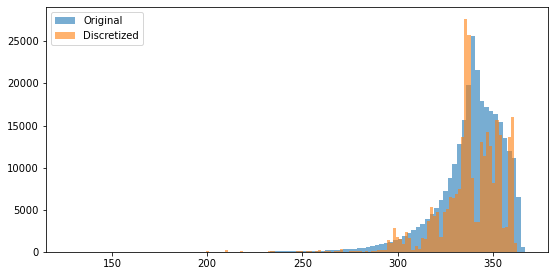

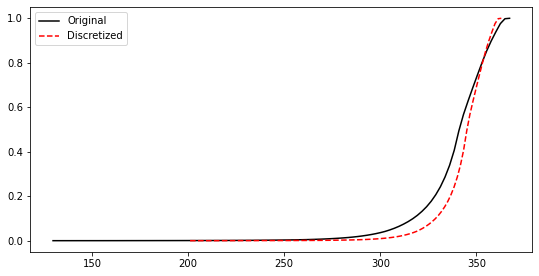

In [5]:
# Choose how many bins you want here
num_bins = 100

# raw sw and its area-based cdf
with rio.open(sw_raster) as ff:
    sw  = ff.read(1)
    sw_mask = ff.read_masks(1)
origin_counts, origin_bin_edges = np.histogram(sw[sw_mask!=0], bins=num_bins)

cum_counts = np.cumsum(origin_counts)
total_count = cum_counts[-1]
origin_cdf = cum_counts/float(total_count)

# discretized sw and its area-based cdf
with rio.open(hru_attrb_sw_mean) as ff:
    dis_sw  = ff.read(1)
    dis_sw_mask = ff.read_masks(1)
    meta = ff.meta
dis_counts, dis_bin_edges = np.histogram(dis_sw[dis_sw_mask!=0], bins=num_bins)
print(meta['dtype'])

cum_counts = np.cumsum(dis_counts)
total_count = cum_counts[-1]
dis_cdf = cum_counts/float(total_count)

# Plot comparatives histogram
fig, ax = plt.subplots(figsize=(9, 9*0.5))
ax.hist(sw[sw_mask!=0], bins=num_bins, alpha=0.6, label='Original')
ax.hist(dis_sw[dis_sw_mask!=0], bins=num_bins, alpha=0.6, label='Discretized')
plt.legend(loc='best')
plt.show()
ax.set_xlabel('Radiation [W$^2$/m]')
ax.set_ylabel('Frequency')
ax.legend(loc='best', framealpha=0.6, facecolor=None)
fig.savefig(hist_ofile,dpi=150)    

# Plot comparatives cdf
fig, ax = plt.subplots(figsize=(9, 9*0.5))
ax.plot(origin_bin_edges[1:], origin_cdf, '-k', label='Original')
ax.plot(dis_bin_edges[1:], origin_cdf, '--r', label='Discretized')
plt.legend(loc='best')
plt.show()
ax.set_xlabel('Radiation [W$^2$/m]')
ax.set_ylabel('CDF')
ax.legend(loc='best', framealpha=0.6, facecolor=None)
fig.savefig(cdf_ofile,dpi=150)    


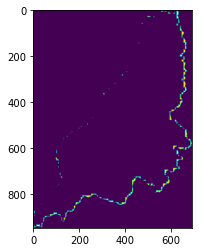

In [13]:
plt.imshow(sw_mask!=dis_sw_mask)

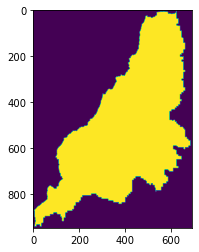

In [11]:
plt.imshow(dis_sw)

In [4]:
in_gpd = gpd.read_file(hru_vector_diss)
in_gpd

,HRUId,index,HRUNo,GRUNo,GRUId,elevClass,lcClass,slpClass,aspClass,sw,areaSqm,elev,lc,geometry
0,14050001010101,1,1,01,140500010101,4,1,1,2,331.2185220189532,2.500585e+06,2302.602783203125,10,"MULTIPOLYGON (((-892494.723 54163.613, -891987..."
1,14050001010102,4,2,01,140500010101,4,2,1,1,343.448505382885,6.634956e+06,2342.0732421875,10,"MULTIPOLYGON (((-894451.679 52569.056, -894379..."
2,14050001010103,2,3,01,140500010101,4,1,1,3,342.1128135107608,6.430076e+06,2376.185791015625,10,"MULTIPOLYGON (((-894306.720 52714.016, -894234..."
3,14050001010104,13,4,01,140500010101,5,2,1,4,353.4035357103194,2.821038e+06,2555.192138671875,10,"MULTIPOLYGON (((-894379.199 52424.096, -894306..."
4,14050001010105,8,5,01,140500010101,5,1,1,2,328.2464528038282,1.209842e+07,2644.34521484375,10,"MULTIPOLYGON (((-892132.324 53583.774, -892059..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,14050001040906,702,6,20,140500010409,2,1,1,2,308.5514673077173,7.197062e+06,2659.124267578125,1,"MULTIPOLYGON (((-863647.738 103087.519, -86357..."
271,14050001040907,712,7,20,140500010409,3,2,1,3,335.1265339301338,1.250293e+06,2801.469482421875,10,"MULTIPOLYGON (((-864010.138 104102.237, -86393..."
272,14050001040908,713,8,20,140500010409,3,2,1,4,357.1250592175348,6.377543e+06,2727.47705078125,10,"MULTIPOLYGON (((-857486.950 107726.230, -85741..."
273,14050001040909,717,9,20,140500010409,4,2,1,2,335.324990092968,3.640558e+06,2767.974365234375,10,"MULTIPOLYGON (((-856544.712 108451.029, -85647..."
